In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import VFDstuff as VFD
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from copy import copy as cp
import matplotlib.path as mpltPath

In [18]:
%matplotlib notebook
fontsize = 25
color = 'k'
linewidth = 4
markersize = 10

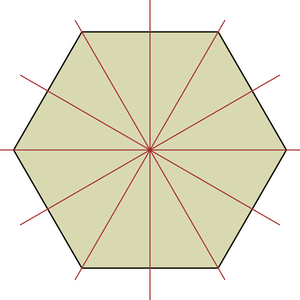

dedge 1.1999999999999993


<IPython.core.display.Javascript object>


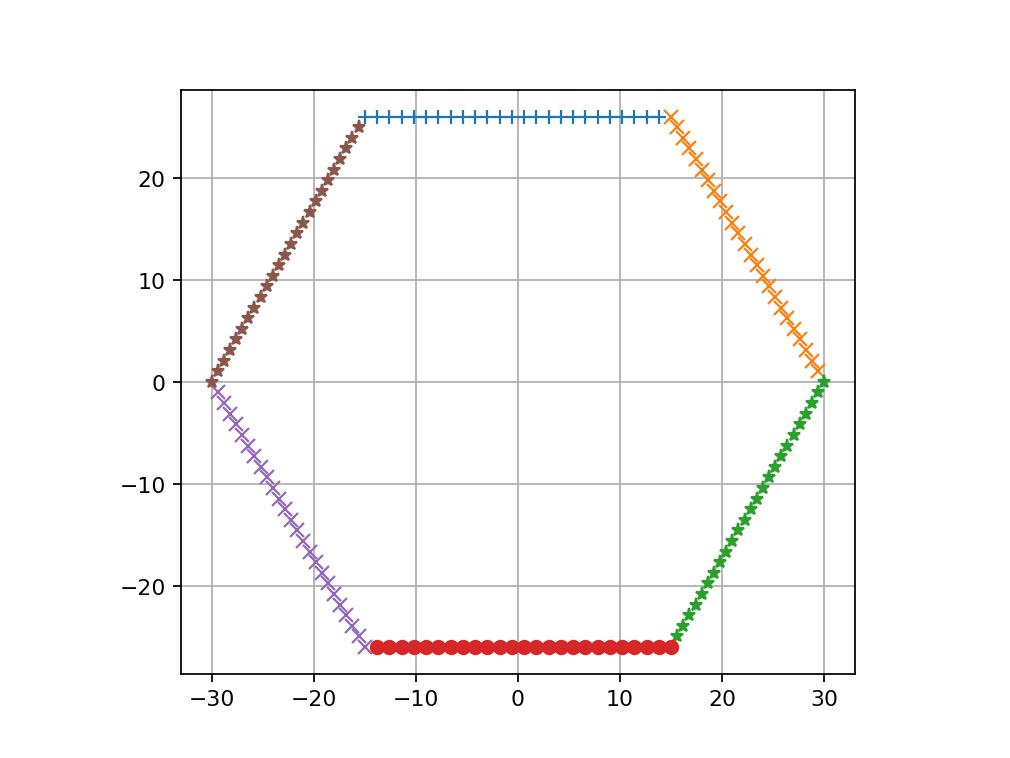

sigma0 =  0.2
Pressure =  50 pascal
Temperature =  240 kelvin
g_ice should be smaller than sigmaI_far_field x nu_kin ...
nu_kin =  39.341788071548116 micrometer / second
sigmaI_far_field x nu_kin =  11.802536421464435 micrometer / second
D0 =  21.893732126411837
loglog method says D =  34908.31943863489 micrometer ** 2 / microsecond
dt =  8.250182324195611e-06 microsecond
Dxeff =  0.19999999999999998 dimensionless
sigmaI_far_field =  0.3
sigmaII_far_field =  0.09999999999999998
Vapor pressure at this temperature =  29.55023347583504 pascal
udirichlet =  38.41530351858555 pascal


In [19]:
# Some key parameters
L = 30
npts = 25
npts_total = npts*6
Lbox_x = L*3.5
Lbox_y = Lbox_x

# Make the top edge
angle = 30*np.pi/180
y0 =L*np.cos(angle)
x_edge0_complete = np.linspace(-L/2,L/2,npts+1); #print(len(x_edge0))
x_edge0 = x_edge0_complete[0:-1]; #print(len(x_edge0))
dedge = x_edge0[1]-x_edge0[0]; print('dedge',dedge)
y_edge0 = np.linspace(y0,y0,npts)
edge0 = np.array([x_edge0,y_edge0]); #print(np.shape(edge0))
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(edge0[0,:],edge0[1,:],'+')
plt.grid(True)

# Make the other edges
angle = 60*np.pi/180
rotation_matrix = np.array([[np.cos(angle),np.sin(angle)],[-np.sin(angle),np.cos(angle)]]); #print(rotation_matrix)
edge1 = np.matmul(rotation_matrix,edge0)
plt.plot(edge1[0,:],edge1[1,:],'x')
edge2 = np.matmul(rotation_matrix,edge1)
plt.plot(edge2[0,:],edge2[1,:],'*')
edge3 = np.matmul(rotation_matrix,edge2)
plt.plot(edge3[0,:],edge3[1,:],'o')
edge4 = np.matmul(rotation_matrix,edge3)
plt.plot(edge4[0,:],edge4[1,:],'x')
edge5 = np.matmul(rotation_matrix,edge4)
plt.plot(edge5[0,:],edge5[1,:],'*')

# Units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'

# Setting ice parameters
sigma0 = 0.2
print('sigma0 = ',sigma0)

# The far-field supersaturation
sigmaI_far_field = 0.3

# Temperature and pressure
Temp = AssignQuantity(240,'kelvin')
Pressure = AssignQuantity(50,'pascal')

# Converting to the desired pressure unit
Pressure.ito(pressure_unit)
print('Pressure = ', Pressure)
print('Temperature = ',Temp)

# Checking on the plausibility of this growth rate
nu_kin = VFD.get_nu_kin(Temp,AssignQuantity)
print('g_ice should be smaller than sigmaI_far_field x nu_kin ...')
print('nu_kin = ', nu_kin)
print('sigmaI_far_field x nu_kin = ', sigmaI_far_field*nu_kin)

# Distance of each pixel
dx = dy = AssignQuantity(dedge,distance_unit)
dx2 = dx**2
dy2 = dy**2

Temp = AssignQuantity(240,'kelvin')
Pressure = AssignQuantity(50,'pascal')

# Compute diffusion coefficient of water through air at this temperature
# This is using trends from engineering toolbox, with the log-log correction
D = VFD.getDofTP(Temp,Pressure,AssignQuantity); print('loglog method says D = ', D)

# Getting a suitable time step
dt = (dx2+dy2)/D/10; print('dt = ', dt)

# Computing effective diffusion coefficents - which should be dimensionless
Dxeff = D*dt/dx2; print('Dxeff = ', Dxeff)

# This assumes the same grid spacing in x and y
Deff = Dxeff

# Growth rate
g_ice = AssignQuantity(2,'micrometer/second')

# Calculating the Neumann condition at the vapor/ice boundary (starting with ice density)
rho_ice = AssignQuantity(0.9,'g/cm^3')
Mvap = AssignQuantity(18,'g/mol')
R = AssignQuantity(8.314,'J/mol/kelvin')

# kappa
kappa = rho_ice*g_ice*R*Temp/(Mvap*dy); kappa.ito(pressure_unit+'/'+time_unit)

# Neumann
uneumann = kappa*dt
uneumann_mag = uneumann.magnitude

# Calculating the dirichlet conditions at the far-field boundary
sigmaII_far_field = sigmaI_far_field - sigma0
print('sigmaI_far_field = ', sigmaI_far_field)
print('sigmaII_far_field = ', sigmaII_far_field)

# Converting this into pressures
P3 = AssignQuantity(611,'Pa')
T3 = AssignQuantity(273,'kelvin')
Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temp-1/T3)); print('Vapor pressure at this temperature = ', P_vapor_eq)

udirichlet = P_vapor_eq*(sigmaI_far_field+1)
print('udirichlet = ', udirichlet)

# Making dimensionless variables for efficiency
udirichlet_mag = udirichlet.magnitude

In [20]:
def position_to_index(x,L,dx):
    index = np.rint((x+L)/dx).astype(int)
    return(index)

def index_to_position(index,L,dx):
    position = index*dx - L
    return(position)

def removedups(mylist):
    
    # Removes duplicates in mylist, preserving the order
    
    seen = set()
    no_dups = []
    for lst in mylist.T:

        # convert to hashable type
        current = tuple(lst)

        # If element not in seen, add it to both
        if current not in seen:
            no_dups.append(lst)
            seen.add(current)
        else:
            print('not keeping', current)
            
    npts_unique, dummy = np.shape(no_dups); #print(npts_unique)
    ixedges_unique = []
    iyedges_unique = []

    for i in range(npts_unique):
        ixedges_unique.append(no_dups[i][0])
        iyedges_unique.append(no_dups[i][1])

    no_dups = np.vstack((ixedges_unique,iyedges_unique))

    return no_dups, npts_unique

def removedups2(mylist1,mylist2):
    
    # Removes any tuple in mylist1 that appears in mylist2
    
    seen = set()
    for lst in mylist2.T:
        current = tuple(lst)
        seen.add(current)
    
    no_dups = []
    for lst in mylist1.T:

        # convert to hashable type
        current = tuple(lst)

        # If element not in seen, add it to both
        if current not in seen:
            no_dups.append(lst)
        else:
            print('not keeping', current)
            
    npts_unique, dummy = np.shape(no_dups); #print(npts_unique)
    ixedges_unique = []
    iyedges_unique = []

    for i in range(npts_unique):
        ixedges_unique.append(no_dups[i][0])
        iyedges_unique.append(no_dups[i][1])

    no_dups = np.vstack((ixedges_unique,iyedges_unique))

    return no_dups, npts_unique


def autoscale(ax=None, axis='y', margin=0.1):
    '''Autoscales the x or y axis of a given matplotlib ax object
    to fit the margins set by manually limits of the other axis,
    with margins in fraction of the width of the plot

    Defaults to current axes object if not specified.
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    if ax is None:
        ax = plt.gca()
    newlow, newhigh = np.inf, -np.inf

    for artist in ax.collections + ax.lines:
        x,y = get_xy(artist)
        if axis == 'y':
            setlim = ax.set_ylim
            lim = ax.get_xlim()
            fixed, dependent = x, y
        else:
            setlim = ax.set_xlim
            lim = ax.get_ylim()
            fixed, dependent = y, x

        low, high = calculate_new_limit(fixed, dependent, lim)
        newlow = low if low < newlow else newlow
        newhigh = high if high > newhigh else newhigh

    margin = margin*(newhigh - newlow)

    setlim(newlow-margin, newhigh+margin)

def calculate_new_limit(fixed, dependent, limit):
    '''Calculates the min/max of the dependent axis given 
    a fixed axis with limits
    '''
    if len(fixed) > 2:
        mask = (fixed>limit[0]) & (fixed < limit[1])
        window = dependent[mask]
        low, high = window.min(), window.max()
    else:
        low = dependent[0]
        high = dependent[-1]
        if low == 0.0 and high == 1.0:
            # This is a axhline in the autoscale direction
            low = np.inf
            high = -np.inf
    return low, high

def get_xy(artist):
    '''Gets the xy coordinates of a given artist
    '''
    if "Collection" in str(artist):
        x, y = artist.get_offsets().T
    elif "Line" in str(artist):
        x, y = artist.get_xdata(), artist.get_ydata()
    else:
        raise ValueError("This type of object isn't implemented yet")
    return x, y

dedge 1.1999999999999993


<IPython.core.display.Javascript object>


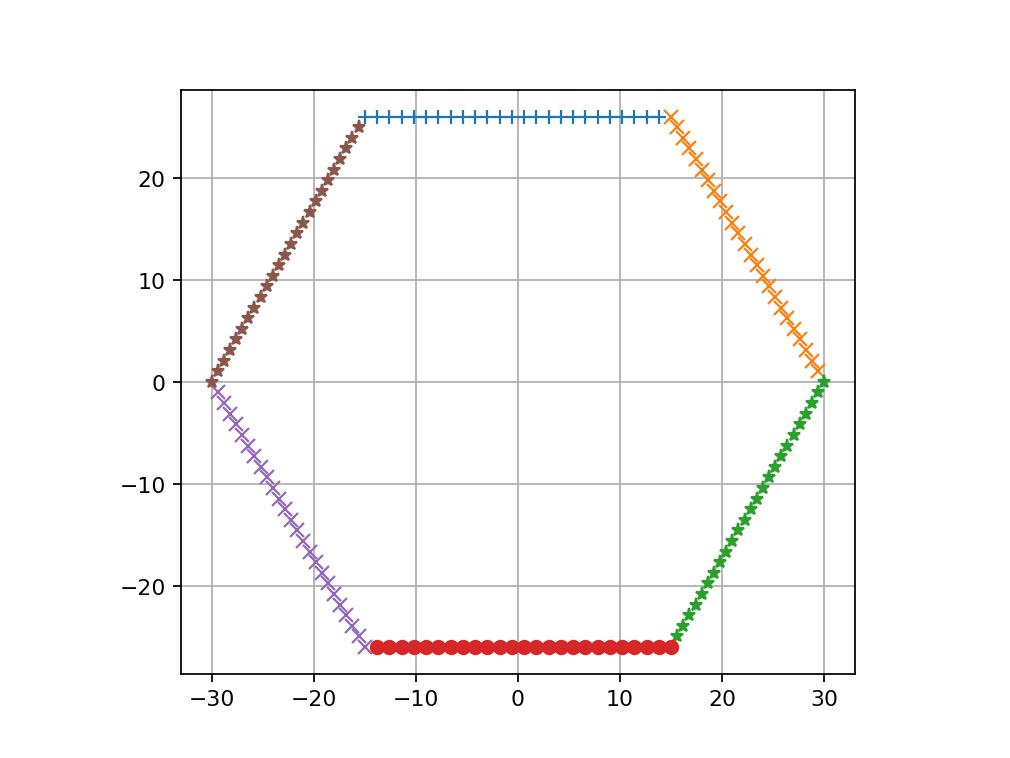

In [21]:
# Total number of points defining the surface of the crystal
npts_total = npts*6

# Make the top edge
angle = 30*np.pi/180
y0 =L*np.cos(angle)
x_edge0 = np.linspace(-L/2,L/2,npts+1); #print(len(x_edge0))
x_edge0 = x_edge0[0:-1]; #print(len(x_edge0))
dedge = x_edge0[1]-x_edge0[0]; print('dedge',dedge)
y_edge0 = np.linspace(y0,y0,npts)
edge0 = np.array([x_edge0,y_edge0]); #print(np.shape(edge0))

fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(edge0[0,:],edge0[1,:],'+')
plt.grid(True)

# Make the other edges
angle = 60*np.pi/180
rotation_matrix = np.array([[np.cos(angle),np.sin(angle)],[-np.sin(angle),np.cos(angle)]]); #print(rotation_matrix)
edge1 = np.matmul(rotation_matrix,edge0)
plt.plot(edge1[0,:],edge1[1,:],'x')
edge2 = np.matmul(rotation_matrix,edge1)
plt.plot(edge2[0,:],edge2[1,:],'*')
edge3 = np.matmul(rotation_matrix,edge2)
plt.plot(edge3[0,:],edge3[1,:],'o')
edge4 = np.matmul(rotation_matrix,edge3)
plt.plot(edge4[0,:],edge4[1,:],'x')
edge5 = np.matmul(rotation_matrix,edge4)
plt.plot(edge5[0,:],edge5[1,:],'*')

<IPython.core.display.Javascript object>


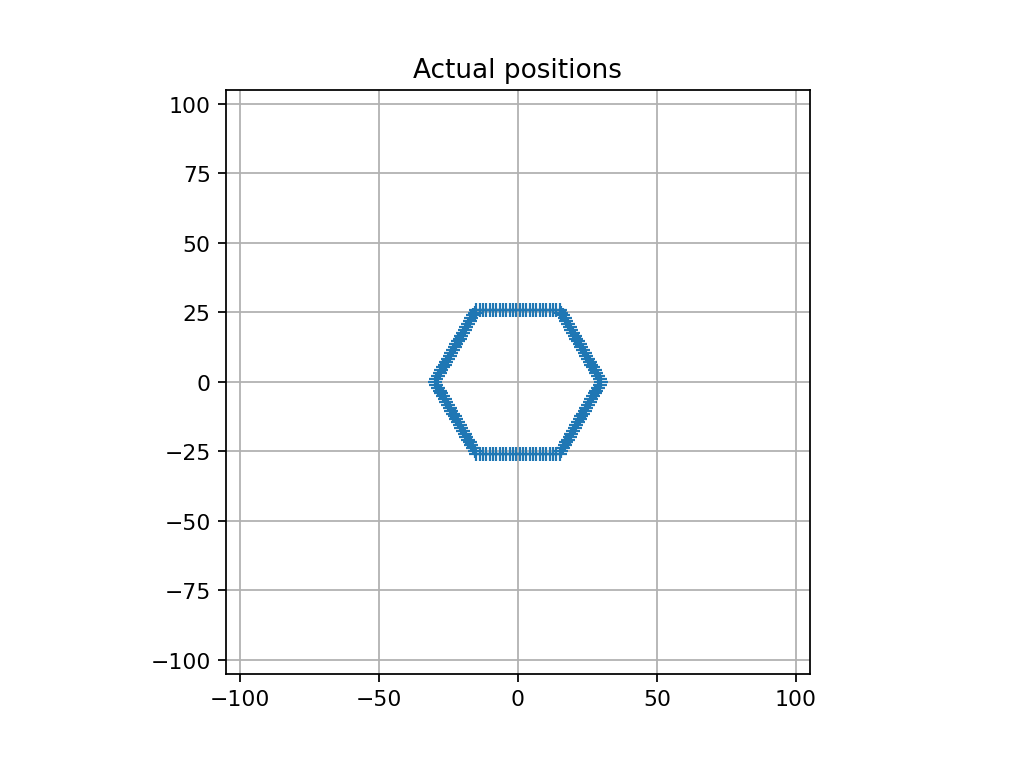

Text(0.5, 1.0, 'Actual positions')

In [22]:
# Gather all the edges together as one big array
edges = np.hstack([edge0,edge1,edge2,edge3,edge4,edge5])
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(edges[0,:],edges[1,:],'+')
plt.grid(True)
plt.xlim(-Lbox_x,Lbox_x)
plt.ylim(-Lbox_y,Lbox_y)
plt.title('Actual positions')

In [23]:
# Create the simulation box
xarray = np.arange(-Lbox_x,Lbox_x+dedge,dedge)
yarray = np.arange(-Lbox_y,Lbox_y+dedge,dedge)
ygrid,xgrid = np.meshgrid(yarray,xarray)
nx,ny = np.shape(xgrid)
print(nx,ny)

177 177


<IPython.core.display.Javascript object>


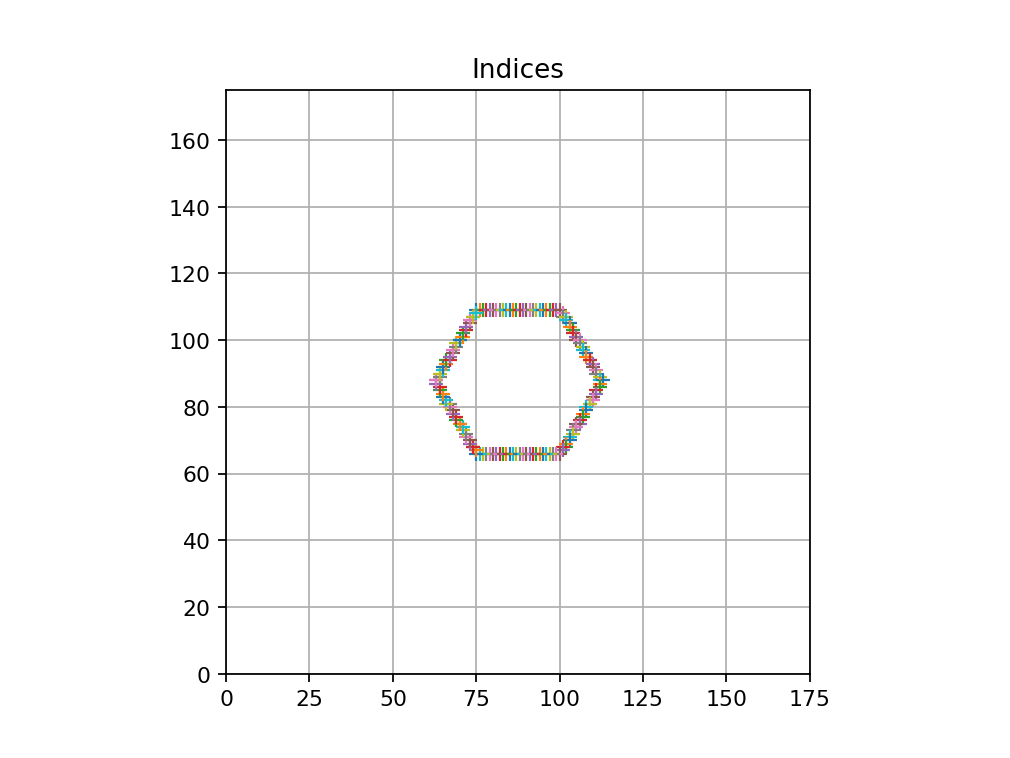

0
175
0
175
not keeping (109, 94)
not keeping (109, 81)
not keeping (74, 68)
not keeping (70, 75)
not keeping (63, 88)
not keeping (70, 100)
not keeping (74, 107)
(2, 150)
(2, 143)


In [24]:
# Find indices of the crystal boundary
ixedges = position_to_index(edges[0,:],Lbox_x,dedge); #print(edges,ixedges)
iyedges = position_to_index(edges[1,:],Lbox_y,dedge); #print(iyedges)
iedges = np.vstack((ixedges,iyedges))

# Plot in "index space"
fig, ax = plt.subplots()
ax.set_aspect('equal')
for i in range(npts_total):
    plt.plot(iedges[0,i],iedges[1,i],'+')
iLbox_xmin = position_to_index(-Lbox_x,Lbox_x,dedge); print(iLbox_xmin)
iLbox_xmax = position_to_index( Lbox_x,Lbox_x,dedge); print(iLbox_xmax)
iLbox_ymin = position_to_index(-Lbox_y,Lbox_y,dedge); print(iLbox_ymin)
iLbox_ymax = position_to_index( Lbox_y,Lbox_y,dedge); print(iLbox_ymax)
plt.xlim(iLbox_xmin,iLbox_xmax)
plt.ylim(iLbox_ymin,iLbox_ymax)
plt.grid(True)
plt.title('Indices')

# Remove duplicates in the indices of the crystal boundary
iedges_unique, npts_unique = removedups(iedges)
print(np.shape(iedges))
print(np.shape(iedges_unique))

not keeping (67, 94)
not keeping (76, 109)
not keeping (77, 109)
not keeping (78, 109)
not keeping (79, 109)
not keeping (80, 109)
not keeping (81, 109)
not keeping (82, 109)
not keeping (83, 109)
not keeping (84, 109)
not keeping (85, 109)
not keeping (86, 109)
not keeping (87, 109)
not keeping (88, 109)
not keeping (89, 109)
not keeping (90, 109)
not keeping (91, 109)
not keeping (92, 109)
not keeping (93, 109)
not keeping (94, 109)
not keeping (95, 109)
not keeping (96, 109)
not keeping (97, 109)
not keeping (98, 109)
not keeping (99, 109)
not keeping (101, 107)
not keeping (105, 100)
not keeping (112, 88)


<IPython.core.display.Javascript object>


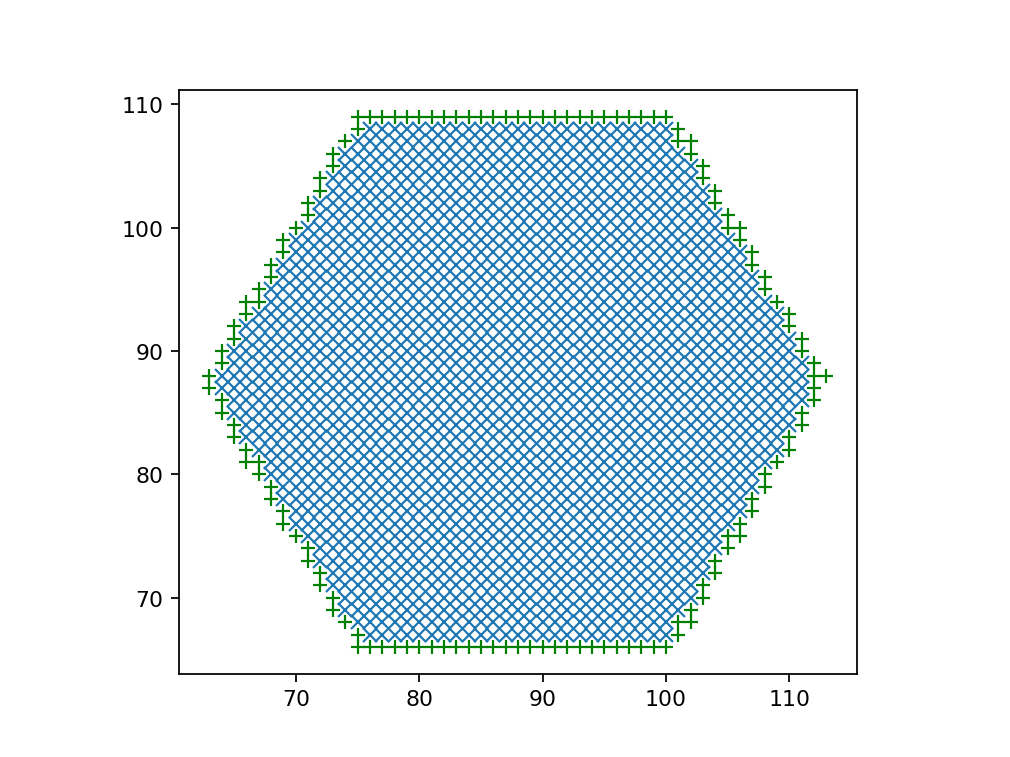

In [25]:
# Getting indices of pixels inside the crystal
iedges_unique_float = iedges_unique.astype(float)
polygon = iedges_unique_float.T
path = mpltPath.Path(polygon); #print(path)
ix_inside = []
iy_inside = []
for ix in range(nx):
    for iy in range(ny):
        inside = path.contains_points([[ix,iy]])
        if inside:
            ix_inside.append(ix)
            iy_inside.append(iy)
i_inside = np.vstack((ix_inside,iy_inside))
i_inside_unique, n_inside_unique = removedups2(i_inside,iedges_unique)
ix_inside_unique = i_inside_unique[0,:]
iy_inside_unique = i_inside_unique[1,:]
fig, ax = plt.subplots()
ax.set_aspect('equal')
for i in range(npts_unique):
    plt.plot(iedges_unique[0,i],iedges_unique[1,i],'+g')
plt.plot(ix_inside_unique,iy_inside_unique,'x')

<IPython.core.display.Javascript object>


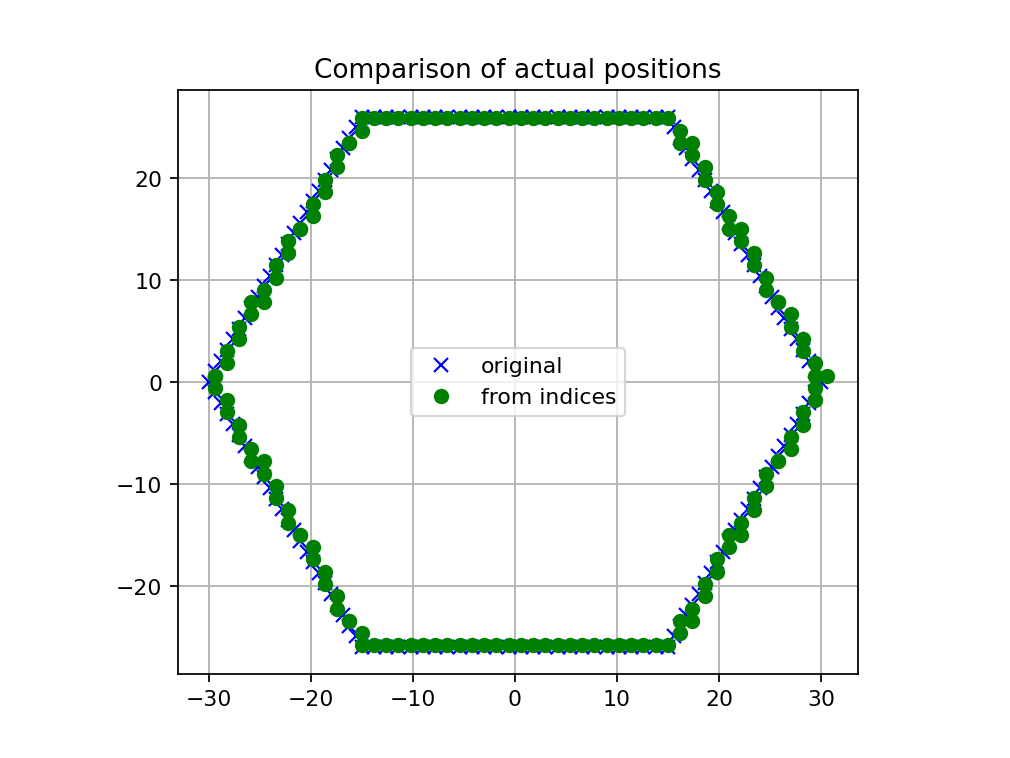

In [26]:
# Checking to make sure the indexed positions are not too far off
xedges_again = index_to_position(ixedges,Lbox_x,dedge)
yedges_again = index_to_position(iyedges,Lbox_y,dedge)
edges_again = np.vstack((xedges_again,yedges_again))
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(edges[0,:],edges[1,:],'bx',label='original')
plt.plot(edges_again[0,:],edges_again[1,:],'go',label='from indices')
plt.grid(True)
plt.title('Comparison of actual positions')
plt.legend()

176 176


<IPython.core.display.Javascript object>


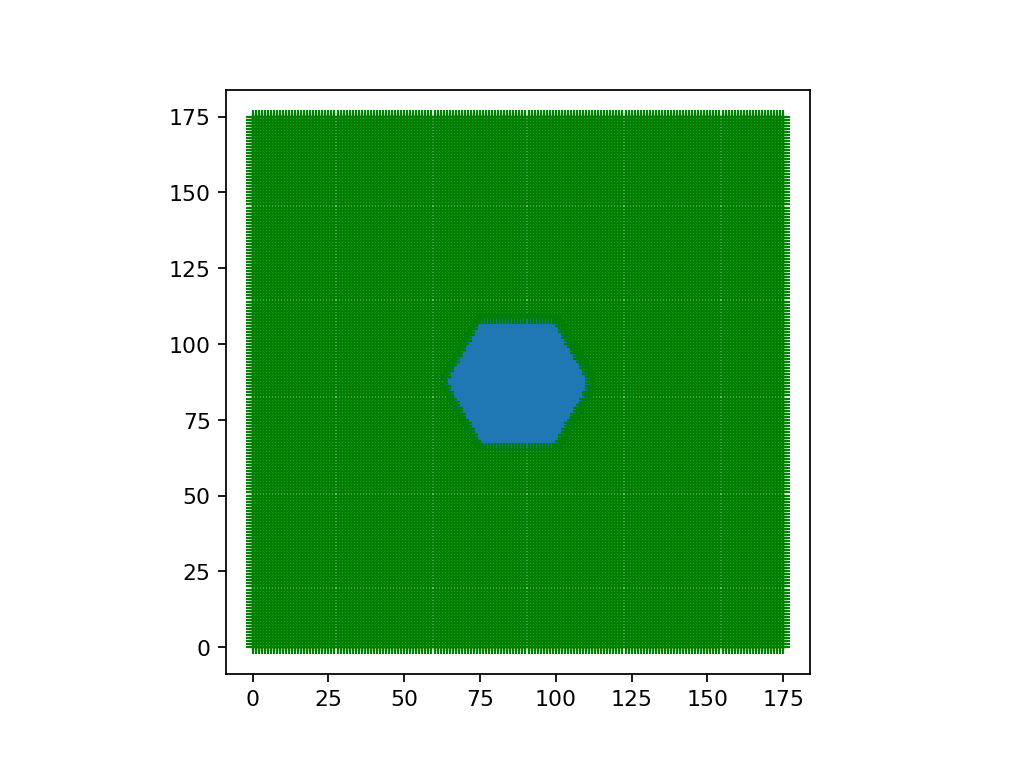

In [27]:
# Calculating the diffusion coefficient matrix, with zeros for in and around the crystal
Dmatrix = np.ones((nx-1,ny-1))*Deff.magnitude
nx_D, ny_D = np.shape(Dmatrix)
print(nx_D, ny_D)
for i in range(n_inside_unique):
    Dmatrix[i_inside_unique[0,i],i_inside_unique[1,i]] = 0
    Dmatrix[i_inside_unique[0,i]-1,i_inside_unique[1,i]] = 0
#     Dmatrix[i_inside_unique[0,i]+1,i_inside_unique[1,i]] = 0
    Dmatrix[i_inside_unique[0,i],i_inside_unique[1,i]-1] = 0
#     Dmatrix[i_inside_unique[0,i],i_inside_unique[1,i]+1] = 0

# Checking    
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(ix_inside_unique,iy_inside_unique,'x')
for ix in range(nx_D):
    for iy in range(ny_D):
        if Dmatrix[ix,iy] != 0:
            plt.plot(ix,iy,'+g',)

In [28]:
# Calculating the dirichlet conditions at the far-field boundary as supersaturations
sigmaII_far_field = sigmaI_far_field - sigma0
print('sigmaI_far_field = ', sigmaI_far_field)
print('sigmaII_far_field = ', sigmaII_far_field)

# Converting supersaturations into pressures
P3 = AssignQuantity(611,'Pa')
T3 = AssignQuantity(273,'kelvin')
Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temp-1/T3)); print('Vapor pressure at this temperature = ', P_vapor_eq)
udirichlet = P_vapor_eq*(sigmaI_far_field+1)
print('udirichlet = ', udirichlet)

sigmaI_far_field =  0.3
sigmaII_far_field =  0.09999999999999998
Vapor pressure at this temperature =  29.55023347583504 pascal
udirichlet =  38.41530351858555 pascal


In [29]:
def propagate_hexagon(u0,udirichlet,uneumann,Deff,Dmatrix,iedges,npts_total):

    # Propagates the vapor field forward one time step
    
    # Initialize starting values
    un = np.zeros(np.shape(u0))

    # Diffusion throughout (this is wrong)
    un[1:-1, 1:-1] = u0[1:-1, 1:-1] + ( \
    ( (u0[2:, 1:-1] - u0[1:-1, 1:-1])*Dmatrix[1:,1:] + (u0[0:-2, 1:-1] -u0[1:-1, 1:-1])*Dmatrix[0:-1,1:] ) + \
    ( (u0[1:-1, 2:] - u0[1:-1, 1:-1])*Dmatrix[1:,1:] + (u0[1:-1, 0:-2] -u0[1:-1, 1:-1])*Dmatrix[1:,0:-1] ) )
    
    # Assigning Dirichlet conditions at the perimeter of the simulation box
    un[[0,-1],:] = udirichlet
    un[:,[0,-1]] = udirichlet
    
    # Assigning Neumann conditions above the crystal surface
    for i in range(npts_total):
        un[iedges[0,i],iedges[1,i]] -= uneumann
            
    return(un)

In [30]:
# Decide on a time to propagate forward
tmax = AssignQuantity(1,time_unit)
ntimes = int(tmax/dt)
print('Integrating steps = ', ntimes)
print('Integrating out to ', ntimes*dt) # This is a check -- it should be very close to the tmax specified above

# Propagate forward in time
un = np.zeros(np.shape(xgrid))
for i in range(ntimes):
    un = propagate_hexagon(\
        un,udirichlet.magnitude,uneumann.magnitude,Deff.magnitude,Dmatrix,\
        iedges, npts_total)

Integrating steps =  121209
Integrating out to  0.9999963493334258 microsecond


88
88
109
66


<IPython.core.display.Javascript object>


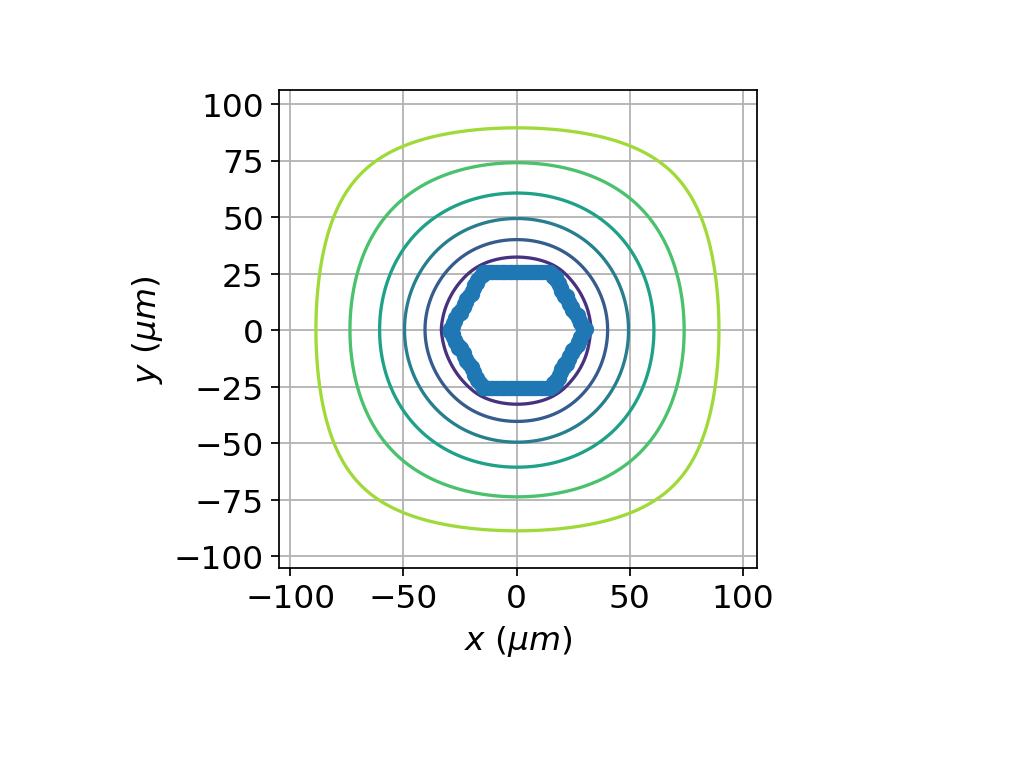

<IPython.core.display.Javascript object>


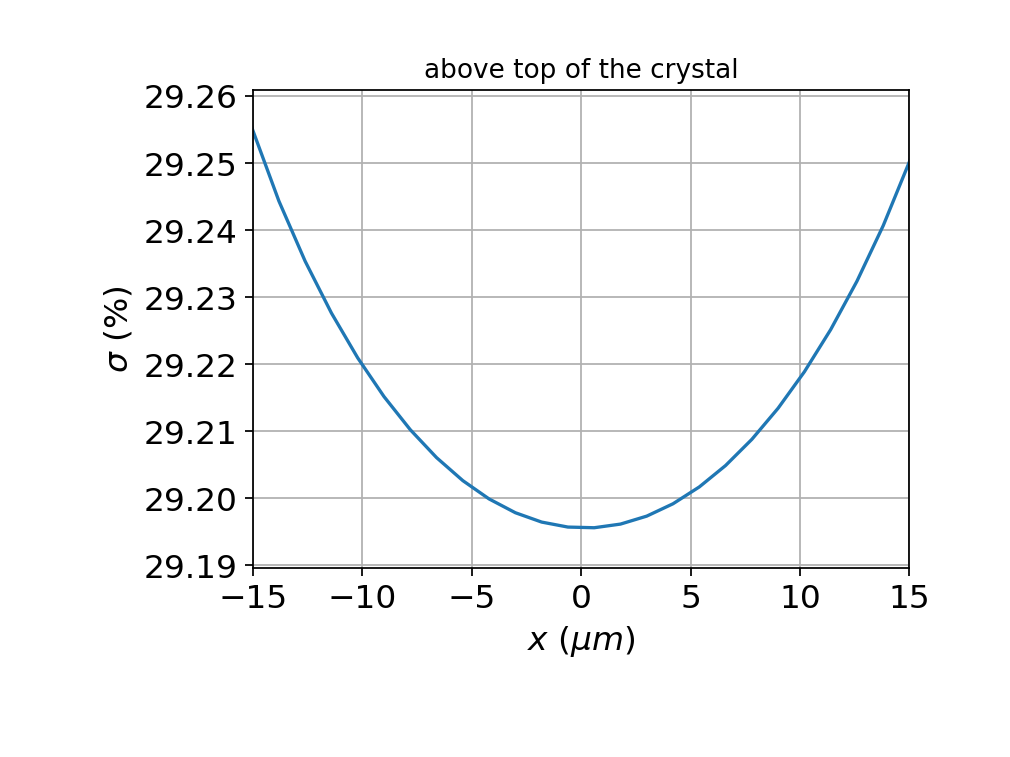

c_r(%) = 0.6187761420886382


<IPython.core.display.Javascript object>


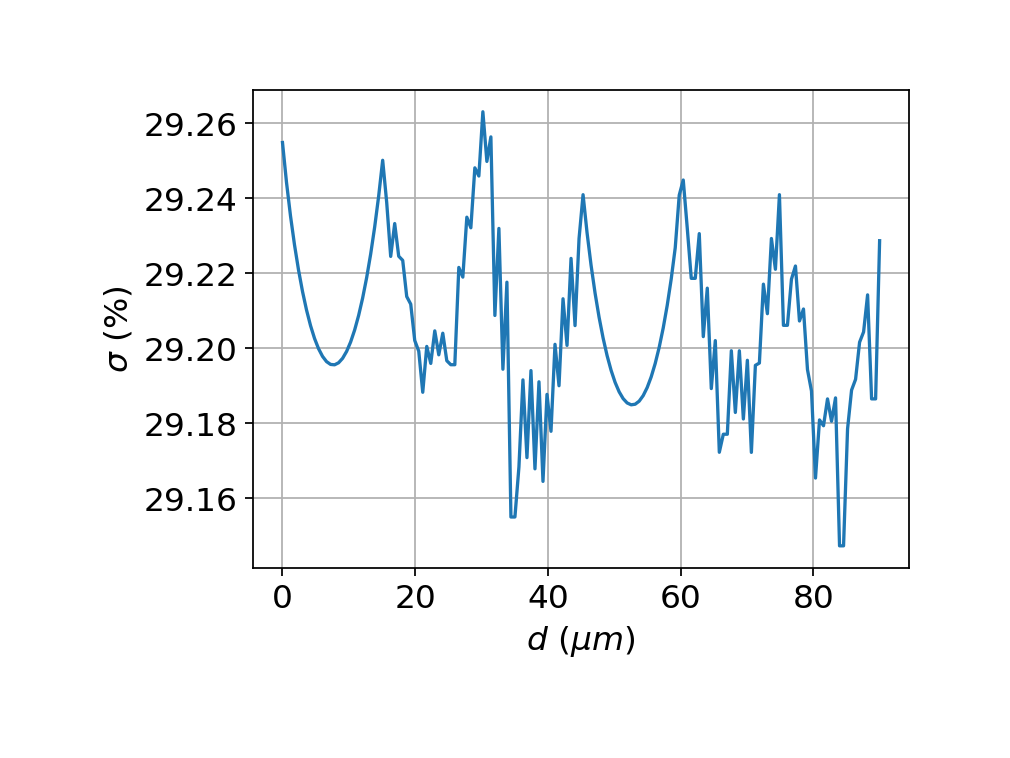

<IPython.core.display.Javascript object>


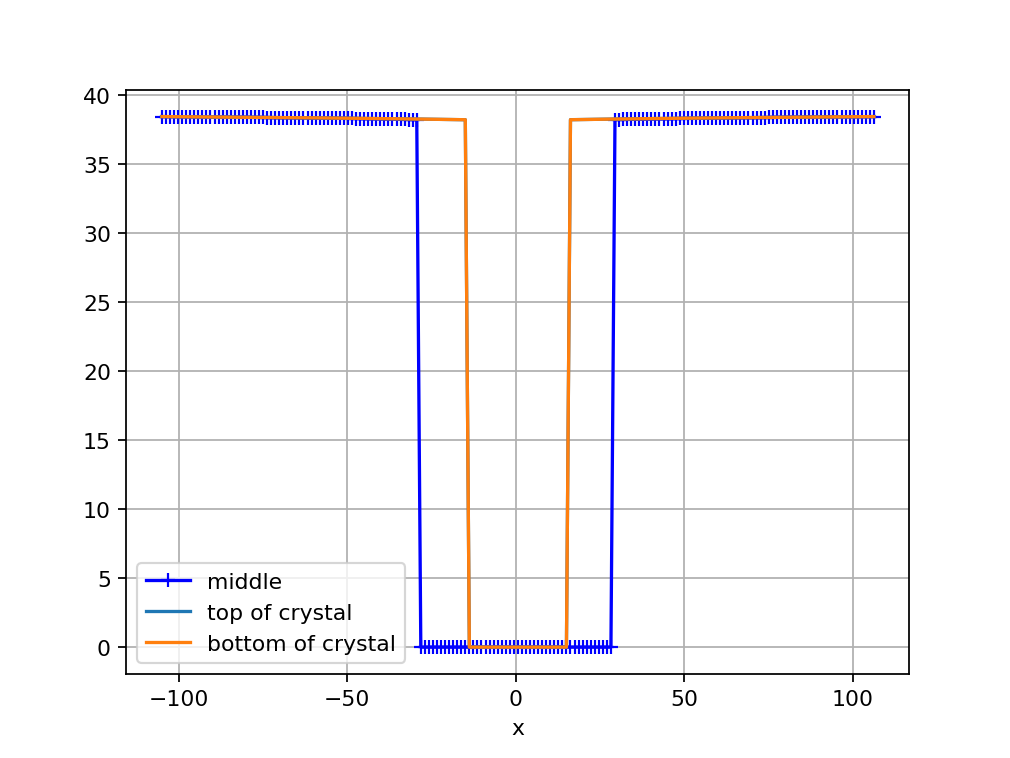

In [60]:
# Specifying larger fonts, etc.
fontsize = 15
margin = 0.25

# Select some points to help with contouring and slicing
ixmid = position_to_index(0,Lbox_x,dedge); print(ixmid)
iymid = position_to_index(0,Lbox_y,dedge); print(iymid)
iyabove = position_to_index(y0,Lbox_y,dedge); print(iyabove)
iybelow = position_to_index(-y0,Lbox_y,dedge); print(iybelow)

# Graph as contour plot
un1 = un[ixmid,iyabove]
un2 = udirichlet_mag
nlevels = 8
levels = np.linspace(un1,un2,nlevels)
fig,ax = plt.subplots()
ax.set_aspect('equal')
CS = ax.contour(xarray,yarray,un.T,levels)
ax.set_xlabel('$x$ ($\mu m$)', fontsize=fontsize)
ax.set_ylabel('$y$ ($\mu m$)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin)
plt.grid(True)
# fig.colorbar(CS)
plt.plot(edges_again[0,:],edges_again[1,:],'o')

# Horizontal slice that goes across a crystal face
fig,ax = plt.subplots()
sigma_percent = (un[:,iyabove]/P_vapor_eq.magnitude-1)*100
plt.plot(xarray,sigma_percent)
plt.grid(True)
plt.xlim(-L/2,L/2)
autoscale(ax, 'y')
plt.xlabel('$x$ ($\mu m$)', fontsize=fontsize)
plt.ylabel('$\sigma$ (%)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin) 
plt.subplots_adjust(left=margin) 
plt.title('above top of the crystal')
c_r_percent = (np.max(un[:,iyabove])-np.min(un[:,iyabove]))/np.max(un[:,iyabove])*100
print('c_r(%) =', c_r_percent)

# Horizontal slice that goes across all the crystal faces
fig,ax = plt.subplots()
sigma_percent = (un[ixedges,iyedges]/P_vapor_eq.magnitude-1)*100
distance_around = np.linspace(0,L*6/2,npts_total)
plt.plot(distance_around,sigma_percent)
plt.grid(True)
plt.xlabel('$d$ ($\mu m$)', fontsize=fontsize)
plt.ylabel('$\sigma$ (%)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin) 
plt.subplots_adjust(left=margin) 

# Horizontal slices that go through the crystal to make sure Pvap -> 0 inside
plt.figure()
plt.plot(xarray,un[:,iymid],'b-+',label='middle')
plt.plot(xarray,un[:,iyabove-1],label='top of crystal')
plt.plot(xarray,un[:,iybelow+1],label='bottom of crystal')
plt.grid(True)
plt.xlabel('x')
plt.legend()